In [1]:
import sys
sys.path.insert(0, '../../../network')
import logging
import argparse
import numpy as np
from network import Population, RateNetwork
from learning import ReachingTask
from transfer_functions import ErrorFunction
from connectivity import SparseConnectivity, LinearSynapse, ThresholdPlasticityRule, set_connectivity, corticostriatal
from sequences import GaussianSequence
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
logging.basicConfig(level=logging.INFO)

### Initialization

In [2]:
params = np.load("./ctx_str_params.npz", allow_pickle=True) 
N, sequences, patterns, cp, cw, A = params['N'], params['sequences'], params['patterns'], params['cp'], params['cw'], params['A']

In [3]:
phi = ErrorFunction(mu=0.22, sigma=0.1).phi

plasticity = ThresholdPlasticityRule(x_f=0.5, q_f=0.8)

# populations
ctx = Population(N=N[0], tau=1e-2, phi=phi, name='ctx')
d1 = Population(N=N[1], tau=1e-2, phi=phi, name='d1')

J = set_connectivity([ctx, d1], cp, cw, A, patterns, plasticity)
network = RateNetwork([ctx, d1], J, formulation=4, disable_pbar=False)

INFO:connectivity:Building connections from ctx to ctx
INFO:connectivity:Building connections from ctx to d1
INFO:connectivity:Building connections from d1 to ctx
INFO:connectivity:Building connections from d1 to d1


### Simulation

In [4]:
# # Specific input
init_inputs = [patterns[0][0][3],
               patterns[1][0][3]]
# Zero input
# init_inputs = [np.zeros(ctx.size),
#                np.zeros(d1.size)]
input_patterns = [p[0] for p in patterns]

T=1#ms
mouse = ReachingTask()
network.simulate_learning(mouse, T, init_inputs, input_patterns, plasticity, 
                          delta_t=40, eta=0.05, tau_e=1500, lamb=0.6, 
                          noise=[0.13,0.13,0.13], e_bl = [0.05, 0.013, 0.02, 0.05], # 0.005
                          alpha=0, gamma=0, adap=0, env=5, etrace=False,  
                          r_ext=[lambda t:0, lambda t: 1], print_output=True, track=False)

INFO:network:Integrating network dynamics
  3%|▎         | 27/999 [00:02<01:11, 13.67it/s]

null-->scavenge
None 0


 37%|███▋      | 365/999 [00:04<00:02, 243.48it/s]

[3, 3] 289
[-1, 3] 3
scavenge-->aim
[-1, 0] 27


 60%|██████    | 601/999 [00:04<00:01, 256.28it/s]

[0, 0] 199
[0, -1] 0
aim-->lick
[0, 2] 13
[-1, 2] 8
[2, 2] 3
[-1, 2] 1


 86%|████████▋ | 862/999 [00:06<00:00, 255.74it/s]

[2, 2] 235
[2, 3] 7
lick-->scavenge
[-1, 3] 19


100%|██████████| 999/999 [00:06<00:00, 152.26it/s]


### Results

In [5]:
overlaps_ctx = sequences[0][0].overlaps(network.pops[0])
overlaps_d1 = sequences[1][0].overlaps(network.pops[1])
# overlaps_d2 = sequences[2][0].overlaps(network.po725206ps[2])
# filename = 'simulation-test'
np.savez('/work/jp464/striatum-sequence/' + 'simulation-pre-learning' + '.npz', 
         overlaps_ctx=overlaps_ctx, overlaps_d1=overlaps_d1, 
         state_ctx=network.pops[0].state, state_d1=network.pops[1].state,
         evars=mouse.evars)

INFO:sequences:Computing overlaps
100%|██████████| 4/4 [00:00<00:00, 88.41it/s]
INFO:sequences:Computing overlaps
100%|██████████| 4/4 [00:00<00:00, 1048.44it/s]


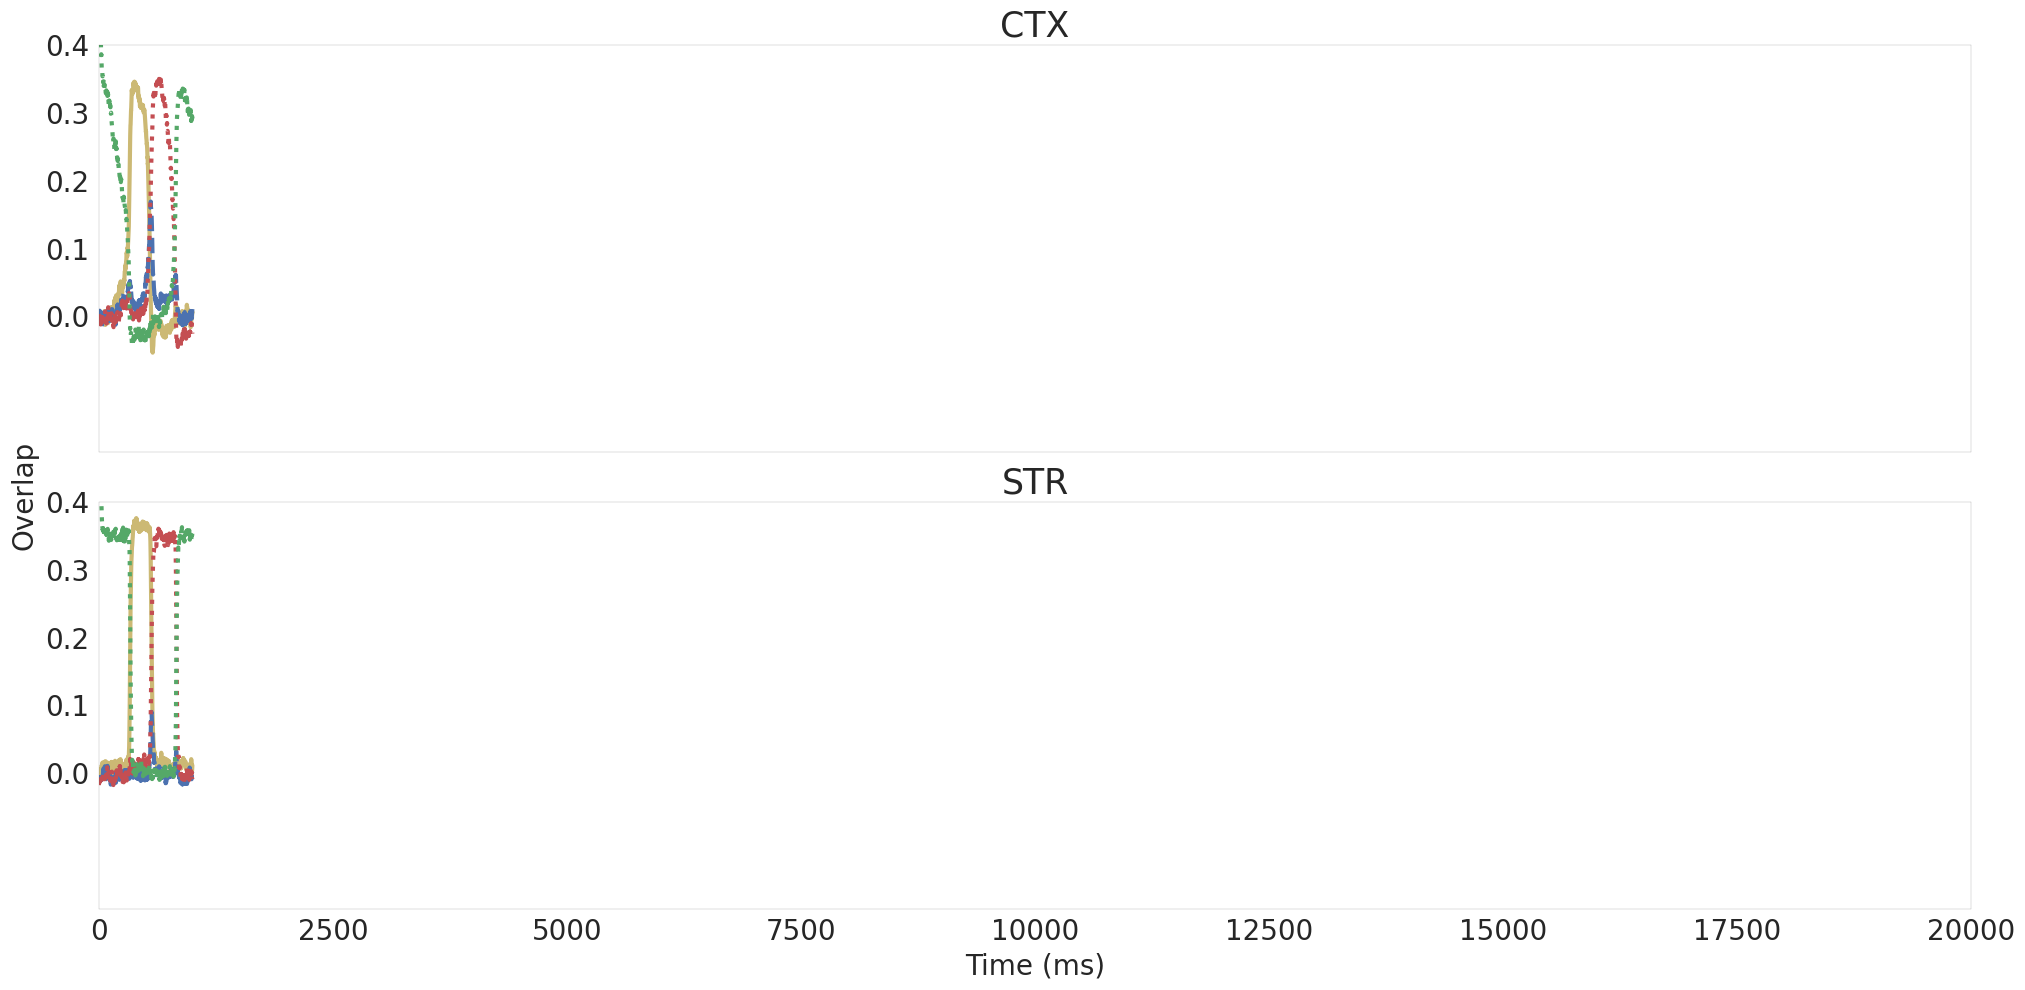

In [6]:
sns.set_style('white') 
colors = sns.color_palette('deep')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rcParams['axes.linewidth'] = 0.1

fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, tight_layout=True, figsize=(20,10))
axes[0].plot(overlaps_ctx[0], linestyle='solid', linewidth=3, color=colors[8], label='Aim')
axes[0].plot(overlaps_ctx[1], linestyle='dashed', linewidth=3, color=colors[0], label='Reach')
axes[0].plot(overlaps_ctx[2], linestyle='dotted', linewidth=3, color=colors[3], label='Lick')
axes[0].plot(overlaps_ctx[3], linestyle='dotted', linewidth=3, color=colors[2], label='Scavenge')
axes[0].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[0].set_title("CTX", fontsize=25)
# axes.set_xlabel('Time (ms)', fontsize=20)
axes[1].plot(overlaps_d1[0], linestyle='solid', linewidth=3, color=colors[8])
axes[1].plot(overlaps_d1[1], linestyle='dashed', linewidth=3, color=colors[0])
axes[1].plot(overlaps_d1[2], linestyle='dotted', linewidth=3, color=colors[3])
axes[1].plot(overlaps_d1[3], linestyle='dotted', linewidth=3, color=colors[2])
axes[1].set_yticks([0.0, 0.1, 0.2, 0.3, 0.4])
axes[1].set_title("STR", fontsize=25)
axes[1].set_xlabel('Time (ms)', fontsize=20)
axes[1].set_xlabel('Time (ms)', fontsize=20)

fig.text(-0.01, 0.5, 'Overlap', va='center', rotation='vertical', fontsize=20)
plt.setp(axes, xlim=(0,20000))
plt.setp(axes, ylim=(-.2, .4))
# plt.figlegend(fontsize=20, loc='upper right')
# plt.figlegend(labels=['Aim', 'Reach', 'Lick'], fontsize=20)
plt.savefig('/work/jp464/striatum-sequence/output/fig1.jpg', bbox_inches = "tight", format='jpg')

plt.show()


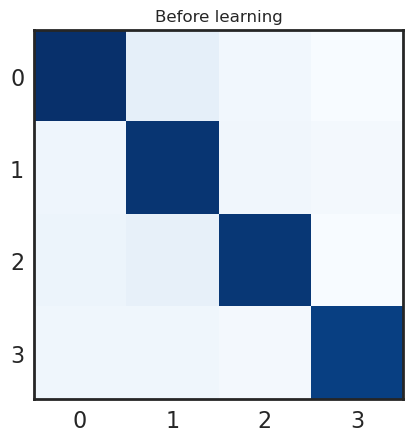

In [16]:
# Set font family globally
import matplotlib as mpl
sns.set_style('white') 
colors = sns.color_palette('deep')
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 
mpl.rcParams['axes.linewidth'] = 2
A = np.around(corticostriatal(J[0][1], input_patterns),4)
plt.imshow(A, cmap='Blues')
plt.title('Before learning')
plt.yticks([0,1,2,3], [0,1,2,3])
plt.savefig('/work/jp464/striatum-sequence/output/learning-associated-patterns-pre.jpg')